In [1]:
import numpy as np
import pandas as pd
import GPy
import pymc3 as pm
from theano import tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from data.get_results import get_results
from likelihood import get_kernel
from acquisitions import phase_ucb_acq1, generate1, log_likelihood, get_likelihood_utility

 E:\Program_Files\Anaconda\envs\testpymc3\lib\site-packages\h5py\__init__.py:36: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


In [2]:
results = get_results('data/results.json').iloc[3:]
function_names = results['function_name'].unique()
kernel_dict = {f: get_kernel(results, GPy.kern.RBF(1), f) for f in function_names}
functions_dict = results[['function_name', 'function']].drop_duplicates(subset = ['function_name']).set_index('function_name').to_dict()['function']
normalized_functions_dict = {f: np.array(functions_dict[f]) / np.std(functions_dict[f]) for f in function_names}

## Simulate actions with negative quadratic reward

In [3]:
neg_quad = normalized_functions_dict['neg_quad']
neg_quad_kern = kernel_dict['neg_quad']
fmax = np.argmax(neg_quad)

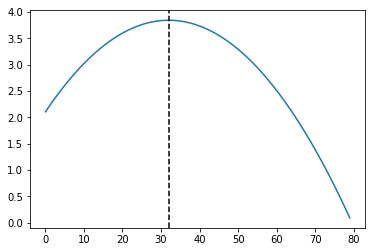

In [4]:
plt.plot(neg_quad);
plt.axvline(x=fmax, ls='--', c='black');

## Strategies

In [5]:
steepness_params = np.array([0, 100, 1])
x_midpoint_params = np.array([10, 20, 10])
yscale_params = np.array([0, 1, 1])
temp_params = np.array([.01, .01, .01])
trials = np.arange(20)
titles = ['Pure Exploit', 'Pure Explore', 'Balanced']

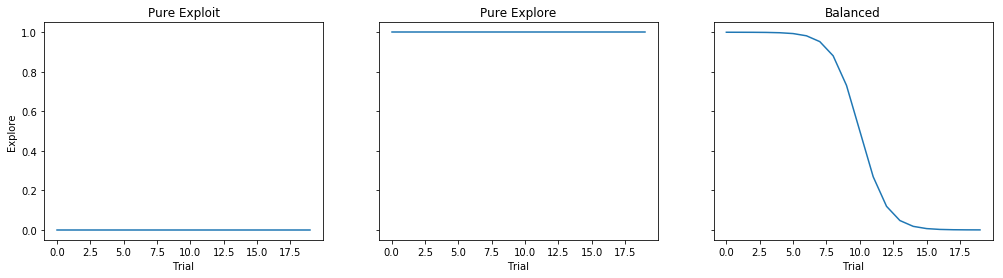

In [6]:
explore = (1 - 1. / (1 + yscale_params[:,None] * np.exp(-steepness_params[:,None] * (trials - x_midpoint_params[:,None]))))
fig, axes = plt.subplots(1, len(steepness_params), sharex=True, sharey=True, figsize=(17, 4))
for i in range(len(axes)):
    axes[i].plot(explore[i])
    axes[i].set_title(titles[i])
    if i == 0:
        axes[i].set_ylabel('Explore')
    axes[i].set_xlabel('Trial')

In [7]:
true_params = {'steepness': steepness_params, 'x_midpoint': x_midpoint_params,
                                  'temperature': temp_params, 'yscale': yscale_params}

In [8]:
data = generate1(phase_ucb_acq1, true_params, neg_quad_kern, neg_quad, 30, 20, 3, np.array([.333, .333, .333]))

In [9]:
actions = data[:,8,:].argmax(axis=1)

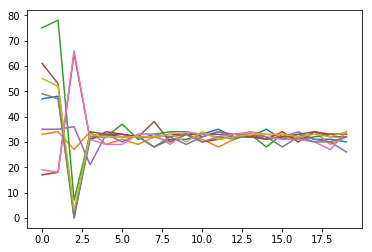

In [10]:
plt.plot(actions[:9].T);

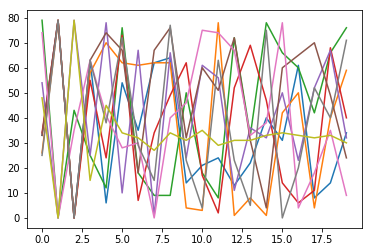

In [11]:
plt.plot(actions[10:19].T);

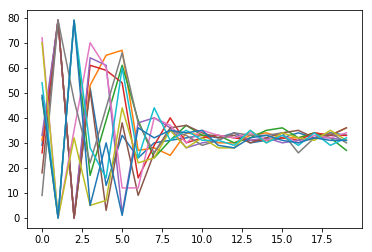

In [12]:
plt.plot(actions[19:].T);

## Infinite Mixture

In [13]:
rerun_inf_mix = False

In [14]:
k=30

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

In [16]:
if rerun_inf_mix:
    with pm.Model() as model:
        steepness = pm.Gamma('steepness', 1., 1., shape=k)
        x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=k)
        yscale = pm.Gamma('yscale', 1., 1., shape=k)
        temperature = pm.Gamma('temperature', .1, .1, shape=k)

        alpha = pm.Gamma('alpha', 1., 1.)
        beta = pm.Beta('beta', 1., alpha, shape=k)
        w = pm.Deterministic('w', stick_breaking(beta))

        obs = pm.Potential('obs', log_likelihood(data, phase_ucb_acq1, {'steepness': steepness, 
                                   'temperature': temperature, 'x_midpoint': x_midpoint,
                                   'yscale': yscale}, k, w))
        inf_mix_trace = pm.sample(200)
        with open('phase_ucb_inf_mix_trace.pkl', 'wb') as f:
            pickle.dump(inf_mix_trace, f)
else:
    with open('phase_ucb_inf_mix_trace.pkl', 'rb') as f:
        inf_mix_trace = pickle.load(f)

### Trace

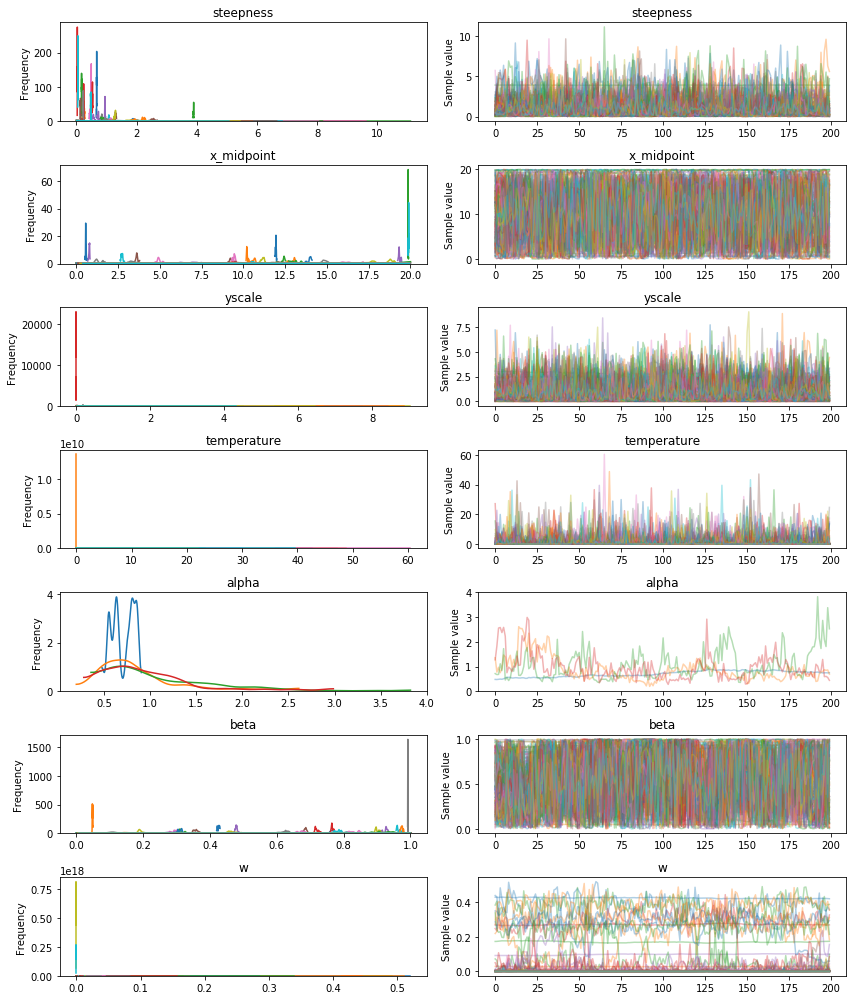

In [18]:
pm.traceplot(inf_mix_trace);

### Components

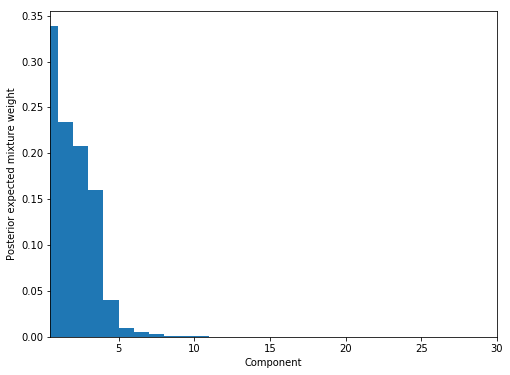

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_w = np.arange(k) + 1
ax.bar(plot_w - 0.5, inf_mix_trace['w'].mean(axis=0), width=1., lw=0);
ax.set_xlim(0.5, k);
ax.set_xlabel('Component');
ax.set_ylabel('Posterior expected mixture weight');

### Recovered Strategies

In [20]:
def phase_ucb_clusters(trace, threshold):
    
    mean_weights = trace['w'].mean(axis=0)
    idx = np.argwhere(mean_weights>=threshold).ravel()
    samples = np.array([[s['steepness'], s['x_midpoint'], s['yscale']] for s in np.array(trace)])[:,:,idx]
    
    position = trials[:,None,None] - samples[:,1,:]
    growth = np.exp(-samples[:,0,:] * position)
    denom = 1 + samples[:,2,:] * growth
    e = 1 - 1. / denom

    mean_e = e.mean(axis=1)
    std_e = e.std(axis=1)
    return mean_e, std_e

In [21]:
def plot_phase_ucb_clusters(mean_e, std_e):
    
    mean_e = mean_e.T
    std_e = std_e.T
    colors = np.array(sns.color_palette("hls", mean_e.shape[0]).as_hex())
    upper = (mean_e + 2 * std_e).clip(min=0, max=1)
    lower = (mean_e - 2 * std_e).clip(min=0, max=1)
    for i in range(len(mean_e)):
        plt.plot(mean_e[i], color=colors[i])
        plt.fill_between(np.arange(len(mean_e[i])), lower[i], upper[i], color=colors[i], alpha=.5)
    

Clusters p>.2

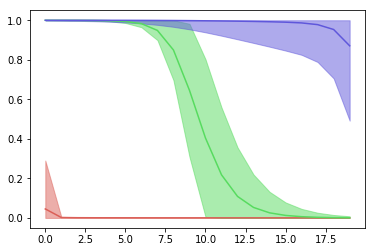

In [24]:
mean_e, std_e = phase_ucb_clusters(inf_mix_trace, .2)
plot_phase_ucb_clusters(mean_e, std_e)

Clusters p>.1

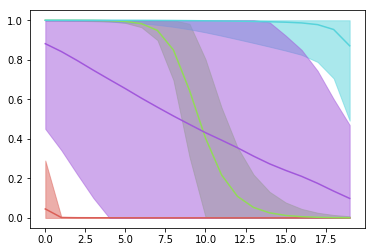

In [28]:
mean_e, std_e = phase_ucb_clusters(inf_mix_trace, .1)
plot_phase_ucb_clusters(mean_e, std_e)